<a href="https://colab.research.google.com/github/RushabhMowade/Amazon-ML-Challenge-2025/blob/Rushabh_branch/Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df=pd.read_csv("/content/drive/MyDrive/Dataset/train.csv")

<Axes: >

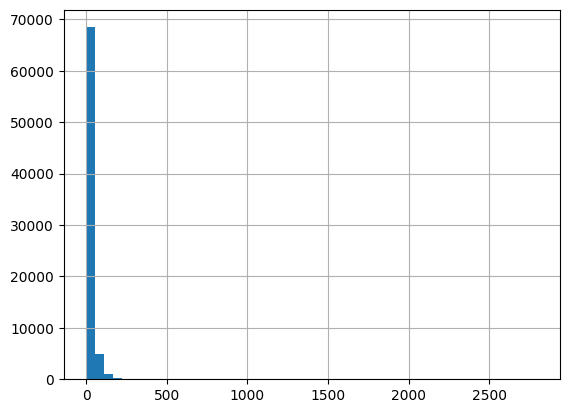

In [ ]:
df["price"].hist(bins=50)



In [5]:
df["price"].skew()

np.float64(13.601388975432753)

In [6]:
df["log_price"] = np.log1p(df["price"])

In [ ]:
df["log_price"].hist(bins=50)

In [7]:
q1 = df["log_price"].quantile(0.25)
q3 = df["log_price"].quantile(0.75)
iqr = q3 - q1
lst = []
for i in df["log_price"]:
  if i < q1 - 1.5 * iqr or i > q3 + 1.5 * iqr:
    lst.append(i)
print(len(lst))

242


In [8]:
df['catalog_content'][5]

"Item Name: Member's Mark Member's Mark, Basil, 6.25 oz\nBullet Point 1: Green Herb, Italian Staple, Great mixed with Oregano\nBullet Point 2: Large Size, Chef Bottle\nBullet Point 3: Packed in the USA\nValue: 6.25\nUnit: ounce\n"

In [9]:
!pip install ftfy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.8 MB/s eta 0:00:00


In [10]:
import ftfy
df['catalog_content'] = df['catalog_content'].apply(lambda x : ftfy.fix_text(x))

In [11]:
print(df['catalog_content'][5])

Item Name: Member's Mark Member's Mark, Basil, 6.25 oz
Bullet Point 1: Green Herb, Italian Staple, Great mixed with Oregano
Bullet Point 2: Large Size, Chef Bottle
Bullet Point 3: Packed in the USA
Value: 6.25
Unit: ounce



In [12]:
import re
df['catalog_content'] = df['catalog_content'].apply(lambda x : re.sub(r'[^\w\s]', '',x))

In [13]:
df['catalog_content'] = df['catalog_content'].apply(lambda x : x.lower())

In [14]:
df['catalog_content'] = df['catalog_content'].apply(lambda x : x.replace("\n",""))

In [ ]:
df['catalog_content'][5]

'item name members mark members mark basil 625 ozbullet point 1 green herb italian staple great mixed with oreganobullet point 2 large size chef bottlebullet point 3 packed in the usavalue 625unit ounce'

In [ ]:
df['catalog_content'].isnull().sum()

np.int64(0)

In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
df.head()

,sample_id,catalog_content,image_link,price,log_price
0,33127,item name la victoria green taco sauce mild 12...,https://m.media-amazon.com/images/I/51mo8htwTH...,4.89,1.773256
1,198967,item name salerno cookies the original butter ...,https://m.media-amazon.com/images/I/71YtriIHAA...,13.12,2.647592
2,261251,item name bear creek hearty soup bowl creamy c...,https://m.media-amazon.com/images/I/51+PFEe-w-...,1.97,1.088562
3,55858,item name judees blue cheese powder 1125 oz g...,https://m.media-amazon.com/images/I/41mu0HAToD...,30.34,3.444895
4,292686,item name kedem sherry cooking wine 127 ounce ...,https://m.media-amazon.com/images/I/41sA037+Qv...,66.49,4.211979


In [15]:
def smape(y_true, y_pred, eps=1e-3):
    y_true = np.clip(y_true, eps, None)
    y_pred = np.clip(y_pred, eps, None)
    return np.mean(
        np.abs(y_pred - y_true) /
        ((np.abs(y_true) + np.abs(y_pred)) / 2)
    )


In [16]:
import os
DATASET_FOLDER = '/content/drive/MyDrive/Dataset'
test = pd.read_csv(os.path.join(DATASET_FOLDER, 'test.csv'))

In [17]:
import sys
sys.path.append('/content/drive/MyDrive/Dataset')

In [ ]:
from utils import download_images
download_images(df['image_link'], '/content/drive/MyDrive/Dataset/images')

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    max_features=30000,
    min_df=5,
    max_df=0.85,
    stop_words="english"
)

L = vectorizer.fit_transform(df["catalog_content"])


In [19]:
def get_image_filename(url):
    return url.split("/")[-1]

In [20]:
df["img_file"] = df["image_link"].apply(get_image_filename)
df[["sample_id", "img_file"]].head()


,sample_id,img_file
0,33127,51mo8htwTHL.jpg
1,198967,71YtriIHAAL.jpg
2,261251,51+PFEe-w-L.jpg
3,55858,41mu0HAToDL.jpg
4,292686,41sA037+QvL.jpg


In [ ]:
#!pip install tensorflow

In [ ]:
import os, numpy as np
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

IMG_DIR = "/content/drive/MyDrive/Dataset/images"
EMB_SIZE = 2048

model = ResNet50(weights="imagenet", include_top=False, pooling="avg")

image_embeddings = []

for fname in df["img_file"]:
    img_path = os.path.join(IMG_DIR, fname)

    try:
        img = load_img(img_path, target_size=(224, 224))
        x = preprocess_input(np.expand_dims(img_to_array(img), 0))
        emb = model.predict(x, verbose=0)[0]
    except Exception:
        emb = np.zeros(EMB_SIZE)

    image_embeddings.append(emb)

image_embeddings = np.vstack(image_embeddings)
np.save('/content/drive/MyDrive/Dataset/emb.npy', image_embeddings)

In [21]:
from scipy.sparse import csr_matrix

In [22]:
from sklearn.preprocessing import normalize
img_emb = np.load('/content/drive/MyDrive/Dataset/Embeddings/emb.npy')

In [23]:
img_emb=normalize(img_emb)

In [24]:
assert img_emb.shape[0] == len(df)

In [25]:
from scipy.sparse import hstack
X = hstack([L,csr_matrix(img_emb)])
y = df["log_price"]

In [26]:
L.shape,img_emb.shape

((75000, 30000), (75000, 2048))

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X , y, test_size=0.2)


In [28]:
import lightgbm as lgb                #Validation SMAPE: 0.5104
model_1 = lgb.LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=63,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model_1.fit(X, y)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 72.477410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1925377
[LightGBM] [Info] Number of data points in the train set: 75000, number of used features: 31185
[LightGBM] [Info] Start training from score 2.739217


LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, n_estimators=1000,
              num_leaves=63, random_state=42, subsample=0.8)

In [32]:


import joblib

# Save BOTH models correctly
joblib.dump(model_1, 'model1.pkl')  # Your sklearn LightGBM model
joblib.dump(vectorizer, 'vectorizer.pkl')

print("✅ Saved model1.pkl & vectorizer.pkl")

# Verify files
!ls -la *.pkl


✅ Saved model1.pkl & vectorizer.pkl
-rw-r--r-- 1 root root 7303210 Feb 27 13:17 model1.pkl
-rw-r--r-- 1 root root 1244294 Feb 27 13:17 vectorizer.pkl


In [ ]:
# y_pred = model_1.predict(X_val)
# pred_price = np.expm1(y_pred)
# pred_price_1 = np.clip(pred_price, 1.0, None)
# true_price = np.expm1(y_val)

In [ ]:
# val_smape = smape(true_price, pred_price_1)
# print("Validation SMAPE:", val_smape)

Applying on Test data

In [ ]:
test['catalog_content'] = test['catalog_content'].apply(lambda x : ftfy.fix_text(x))
test['catalog_content'] = test['catalog_content'].apply(lambda x : re.sub(r'[^\w\s]', '',x))
test['catalog_content'] = test['catalog_content'].apply(lambda x : x.lower())
test['catalog_content'] = test['catalog_content'].apply(lambda x : x.replace("\n",""))

In [ ]:
download_images(test['image_link'],'/content/drive/MyDrive/Dataset/images')

In [ ]:
L_test = vectorizer.transform(test["catalog_content"])

In [ ]:
test["img_file"] = test["image_link"].apply(get_image_filename)
test[["sample_id", "img_file"]].head()

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

IMG_DIR = "/content/drive/MyDrive/Dataset/images"
EMB_SIZE = 2048

model = ResNet50(weights="imagenet", include_top=False, pooling="avg")

image_embeddings = []

for fname in test["img_file"]:
    img_path = os.path.join(IMG_DIR, fname)

    try:
        img = load_img(img_path, target_size=(224, 224))
        x = preprocess_input(np.expand_dims(img_to_array(img), 0))
        emb = model.predict(x, verbose=0)[0]
    except Exception:
        emb = np.zeros(EMB_SIZE)

    image_embeddings.append(emb)

image_embeddings = np.vstack(image_embeddings)
np.save('/content/drive/MyDrive/Dataset/test_emb.npy', image_embeddings)

In [ ]:
img_emb = np.load("/content/drive/MyDrive/Dataset/test_emb.npy")
img_emb=normalize(img_emb)

In [ ]:
X_test = hstack([L_test,csr_matrix(img_emb)])

In [ ]:
y_pred = model_1.predict(X_test)

In [ ]:
pred_price = np.expm1(y_pred)
pred_price = np.clip(pred_price, 1.0, None)

In [ ]:
submission = pd.DataFrame({
    "sample_id": test["sample_id"],
    "price": pred_price
})

submission.to_csv("test_out.csv", index=False)